In [1]:
import pandas as pd
import os
import numpy as np
import epiweeks
import datetime
import requests
import zipfile
import csv
from contextlib import ExitStack
import progressbar as pbar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [2]:
    cases_csv = 'https://raw.githubusercontent.com/KITmetricslab/covid19-forecast-hub-de/master/data-truth/RKI/by_age/truth_RKI-Incident%20Cases%20by%20Age_Germany.csv'
    cases = pd.read_csv(cases_csv)
    cases['age_group'].replace(dict([['A00-A04', '00-04'], ['A05-A14', '05-14'], ['A15-A34', '15-34'],
                                      ['A35-A59', '35-59'], ['A60-A79', '60-79'], ['A80+', '80+']]), inplace=True)
    cases = cases.rename(columns={'age_group': 'Age group'})
    cases

,date,location,location_name,Age group,value
0,2020-03-25,GM,Germany,00-04,32
1,2020-03-25,GM,Germany,05-14,81
2,2020-03-25,GM,Germany,15-34,1045
3,2020-03-25,GM,Germany,35-59,1989
4,2020-03-25,GM,Germany,60-79,754
...,...,...,...,...,...
78739,2022-01-28,GM16,Berlin State,15-34,3720
78740,2022-01-28,GM16,Berlin State,35-59,4127
78741,2022-01-28,GM16,Berlin State,60-79,653
78742,2022-01-28,GM16,Berlin State,80+,230


In [3]:
deaths_csv = 'https://raw.githubusercontent.com/KITmetricslab/covid19-forecast-hub-de/master/data-truth/RKI/by_age/truth_RKI-Incident%20Deaths%20by%20Age_Germany.csv'
deaths = pd.read_csv(deaths_csv)
deaths.loc[deaths['location_name'] == 'Free State of Thuringia', 'location_name'] = 'Free State of Thüringia'
deaths['age_group'].replace(dict([['A00-A04', '00-04'], ['A05-A14', '05-14'], ['A15-A34', '15-34'],
                                  ['A35-A59', '35-59'], ['A60-A79', '60-79'], ['A80+', '80+']]), inplace=True)
deaths.drop(deaths.loc[deaths['age_group']=='unbekannt'].index, inplace=True)
deaths = deaths.rename(columns={'age_group': 'Age group'})
deaths
    

,date,location,location_name,Age group,value
0,2020-03-25,GM,Germany,00-04,0
1,2020-03-25,GM,Germany,05-14,0
2,2020-03-25,GM,Germany,15-34,0
3,2020-03-25,GM,Germany,35-59,1
4,2020-03-25,GM,Germany,60-79,12
...,...,...,...,...,...
49697,2022-01-28,GM16,Berlin State,05-14,0
49698,2022-01-28,GM16,Berlin State,15-34,0
49699,2022-01-28,GM16,Berlin State,35-59,0
49700,2022-01-28,GM16,Berlin State,60-79,1


In [4]:
locations1 = list(deaths['location_name'].unique())
locations2 = ['Total', 'Baden-Württemberg', 'Bayern', 'Bremen', 'Hamburg', 'Hessen', 'Niedersachsen',
              'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Schleswig-Holstein',
              'Brandenburg', 'Mecklenburg-Vorpommern',
              'Sachsen', 'Sachsen-Anhalt', 'Thüringen', 'Berlin']
all_locations = dict(zip(locations2, locations1))
population_excel = './data/Germany/population_2020.xlsx'
population = pd.read_excel(population_excel)
population.columns = ['Age'] + list(population[3:4].to_numpy()[0][1:])
population = population[5:-6].reset_index(drop=True)
population = population.rename(columns=all_locations)
population

C:\ProgramData\Anaconda3\envs\MOCOS\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Age,Baden-Württemberg State,Free State of Bavaria,Berlin State,Brandenburg State,Free Hanseatic City of Bremen,Free Hanseatic City of Hamburg,Hesse State,Mecklenburg-Western Pomerania State,Lower Saxony State,North Rhine-Westphalia State,Rhineland-Palatinate State,Saarland State,Free State of Saxony,Sachsen-Anhalt State,Schleswig-Holstein State,Free State of Thüringia
0,under 1 year,107387.0,128618.0,37757.0,19256.0,6746.0,19859.0,59256.0,12123.0,73678.0,169017.0,37637.0,8185.0,33296.0,16062.0,24550.0,15953.0
1,1 year,109384.0,129057.0,38229.0,20505.0,6968.0,19966.0,60130.0,12882.0,75238.0,171563.0,38057.0,8065.0,34633.0,16905.0,25270.0,16741.0
2,2 years,110542.0,129488.0,38330.0,21760.0,6902.0,19910.0,61517.0,13390.0,76068.0,175522.0,39084.0,8210.0,36141.0,17723.0,26199.0,17580.0
3,3 years,110454.0,129649.0,38440.0,22920.0,6755.0,19827.0,62034.0,13669.0,76877.0,176136.0,39823.0,8467.0,37683.0,18517.0,26529.0,18418.0
4,4 years,110245.0,128899.0,38566.0,23863.0,6695.0,19768.0,62388.0,14088.0,77593.0,177663.0,39864.0,8465.0,38617.0,18880.0,27031.0,18976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,87 years,38312.0,43512.0,10243.0,10105.0,2244.0,5301.0,20549.0,6791.0,27702.0,62723.0,14619.0,3985.0,17717.0,9317.0,9953.0,8377.0
88,88 years,33330.0,38699.0,8576.0,8811.0,1938.0,4580.0,18106.0,6091.0,24439.0,55507.0,12764.0,3583.0,15081.0,8137.0,8488.0,7415.0
89,89 years,29520.0,33392.0,7694.0,7667.0,1749.0,4168.0,15998.0,5061.0,22048.0,49406.0,11429.0,3179.0,13748.0,7079.0,7715.0,6428.0
90,90 years and over,108225.0,122252.0,30029.0,26464.0,7160.0,17250.0,62984.0,16715.0,83231.0,184859.0,43862.0,10966.0,51868.0,24957.0,29586.0,23283.0


In [5]:
    total_deaths_excel = 'https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.xlsx;jsessionid=1A8D9AD59C7B0337F82EF6DBEB7D2749.live721?__blob=publicationFile'
    sheet_name = 'BL_2016_2021_KW_AG_Ins'
    groupby = ['unter … Jahren']
    total_deaths = pd.read_excel(total_deaths_excel, sheet_name=sheet_name)
    total_deaths.columns = ['Nr', 'Year', 'Region', 'Age group'] + list(np.arange(1, 54))
    total_deaths = total_deaths[8:][total_deaths.columns[1:]].fillna(0).replace('X ', 0).reset_index(drop=True)
    total_deaths['Region'].replace(all_locations, inplace=True)
    total_deaths['Age group'].replace({'0-65': '00-65', 'Insgesamt': 'Total', '85 u. mehr': '85+'}, inplace=True)
    total_deaths = total_deaths[total_deaths['Region'] == 'Free State of Saxony'].reset_index(drop=True)
    total_deaths

,Year,Region,Age group,1,2,3,4,5,6,7,...,44,45,46,47,48,49,50,51,52,53
0,2021,Free State of Saxony,Total,2069,1834.0,1709.0,1537.0,1467.0,1388.0,1262.0,...,1318.0,1405.0,1593,1805.0,1877.0,1786.0,1626.0,1492.0,0.0,0
1,2021,Free State of Saxony,00-65,169,170.0,159.0,158.0,168.0,148.0,172.0,...,150.0,144.0,180,202.0,226.0,230.0,199.0,188.0,0.0,0
2,2021,Free State of Saxony,65-75,234,234.0,250.0,195.0,214.0,208.0,189.0,...,185.0,203.0,228,271.0,302.0,257.0,228.0,246.0,0.0,0
3,2021,Free State of Saxony,75-85,708,625.0,548.0,494.0,475.0,470.0,396.0,...,424.0,451.0,482,590.0,578.0,557.0,532.0,451.0,0.0,0
4,2021,Free State of Saxony,85+,958,805.0,752.0,690.0,610.0,562.0,505.0,...,559.0,607.0,703,742.0,771.0,742.0,667.0,607.0,0.0,0
5,2020,Free State of Saxony,Total,1122,1216.0,1090.0,1139.0,1121.0,1132.0,1198.0,...,1212.0,1259.0,1333,1515.0,1655.0,1817.0,2100.0,2385.0,2438.0,2361
6,2020,Free State of Saxony,00-65,142,175.0,135.0,131.0,163.0,135.0,135.0,...,128.0,150.0,136,142.0,158.0,151.0,197.0,190.0,211.0,171
7,2020,Free State of Saxony,65-75,146,168.0,149.0,159.0,144.0,159.0,170.0,...,166.0,163.0,189,161.0,193.0,262.0,238.0,279.0,282.0,277
8,2020,Free State of Saxony,75-85,332,390.0,389.0,393.0,340.0,338.0,396.0,...,379.0,398.0,405,556.0,544.0,620.0,680.0,756.0,786.0,815
9,2020,Free State of Saxony,85+,502,483.0,417.0,456.0,474.0,500.0,497.0,...,539.0,548.0,603,656.0,760.0,784.0,985.0,1160.0,1159.0,1098


In [6]:
    population_excel = './data/Germany/population_2015-2019.xlsx'
    population_old = pd.read_excel(population_excel)
    # population_old = population_old[5:-6].reset_index(drop=True)
    population_old.columns = population.columns
    prior_populations = dict()
    step = len(population) + 1
    for start in range(4, 4 + step * 5, step):
        population_year = int((population_old[start:start + 1].to_numpy()[0][0])[-4:])
        df = population_old[start + 1:start + 1 + len(population)].reset_index(drop=True)
        df['Total'] = df[df.columns[1:]].apply(lambda x: sum(x), axis=1)
        df['Age'] = population['Age']
        df = df.rename(columns=all_locations)
        df.index = df['Age']
        prior_populations[population_year] = df
    prior_populations

C:\ProgramData\Anaconda3\envs\MOCOS\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


{2015:                                  Age Baden-Württemberg State  \
 Age                                                            
 under 1 year            under 1 year                101417.0   
 1 year                        1 year                 99912.0   
 2 years                      2 years                 96971.0   
 3 years                      3 years                 95706.0   
 4 years                      4 years                 94410.0   
 ...                              ...                     ...   
 87 years                    87 years                 38092.0   
 88 years                    88 years                 31494.0   
 89 years                    89 years                 27306.0   
 90 years and over  90 years and over                 91908.0   
 Total                          Total              10879618.0   
 
                   Free State of Bavaria Berlin State Brandenburg State  \
 Age                                                                    

In [7]:
prior_populations = dict()
step = len(population) + 1
for start in range(4, 4 + step * 5, step):
    population_year = int((population_old[start:start + 1].to_numpy()[0][0])[-4:])
    df = population_old[start + 1:start + 1 + len(population)].reset_index(drop=True)
    df['Total'] = df[df.columns[1:]].apply(lambda x: sum(x), axis=1)
    df['Age'] = population['Age']
    df.index = df['Age']
    df = df.rename(columns=all_locations)
    prior_populations[population_year] = df
prior_populations

population['Total'] = population[population.columns[1:]].apply(lambda x: sum(x), axis=1)
population.index = population['Age']
population.rename(columns={'Total': 'Germany'}, inplace=True)
population

,Age,Baden-Württemberg State,Free State of Bavaria,Berlin State,Brandenburg State,Free Hanseatic City of Bremen,Free Hanseatic City of Hamburg,Hesse State,Mecklenburg-Western Pomerania State,Lower Saxony State,North Rhine-Westphalia State,Rhineland-Palatinate State,Saarland State,Free State of Saxony,Sachsen-Anhalt State,Schleswig-Holstein State,Free State of Thüringia,Germany
Age,,,,,,,,,,,,,,,,,,
under 1 year,under 1 year,107387.0,128618.0,37757.0,19256.0,6746.0,19859.0,59256.0,12123.0,73678.0,169017.0,37637.0,8185.0,33296.0,16062.0,24550.0,15953.0,769380.0
1 year,1 year,109384.0,129057.0,38229.0,20505.0,6968.0,19966.0,60130.0,12882.0,75238.0,171563.0,38057.0,8065.0,34633.0,16905.0,25270.0,16741.0,783593.0
2 years,2 years,110542.0,129488.0,38330.0,21760.0,6902.0,19910.0,61517.0,13390.0,76068.0,175522.0,39084.0,8210.0,36141.0,17723.0,26199.0,17580.0,798366.0
3 years,3 years,110454.0,129649.0,38440.0,22920.0,6755.0,19827.0,62034.0,13669.0,76877.0,176136.0,39823.0,8467.0,37683.0,18517.0,26529.0,18418.0,806198.0
4 years,4 years,110245.0,128899.0,38566.0,23863.0,6695.0,19768.0,62388.0,14088.0,77593.0,177663.0,39864.0,8465.0,38617.0,18880.0,27031.0,18976.0,811601.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87 years,87 years,38312.0,43512.0,10243.0,10105.0,2244.0,5301.0,20549.0,6791.0,27702.0,62723.0,14619.0,3985.0,17717.0,9317.0,9953.0,8377.0,291450.0
88 years,88 years,33330.0,38699.0,8576.0,8811.0,1938.0,4580.0,18106.0,6091.0,24439.0,55507.0,12764.0,3583.0,15081.0,8137.0,8488.0,7415.0,255545.0
89 years,89 years,29520.0,33392.0,7694.0,7667.0,1749.0,4168.0,15998.0,5061.0,22048.0,49406.0,11429.0,3179.0,13748.0,7079.0,7715.0,6428.0,226281.0


In [8]:
ratios = pd.read_csv('./data/Germany/positive_test_to_death_days_distribution.csv')
ratios.index = ratios['offset']
ratios = ratios['probs']
ratios

offset
-4     0.000038
-3     0.010615
-2     0.026699
-1     0.037717
 0     0.045984
         ...   
 75    0.000016
 76    0.000016
 77    0.000013
 78    0.000008
 79    0.000005
Name: probs, Length: 84, dtype: float64

In [9]:
IFRs = {
    'O\'Driscoll': {
        '35-59': [0.122, 0.115, 0.128],
        '60-79': [0.992, 0.942, 1.045],
        '80+': [7.274, 6.909, 7.656]
    },
    'Verity': {
        '35-59': [0.349, 0.194, 0.743],
        '60-79': [2.913, 1.670, 5.793],
        '80+': [7.800, 3.800, 13.30]
    },
    'Perez-Saez': {
        '35-59': [0.070, 0.047, 0.097],
        '60-79': [3.892, 2.985, 5.145],
        '80+': [5.600, 4.300, 7.400]
    },
    'Levin': {
        '35-59': [0.226, 0.212, 0.276],
        '60-79': [2.491, 2.294, 3.266],
        '80+': [15.61, 12.20, 19.50]
    },
    'Driscoll (ours)': {
        '35-59': [0.14307525980551028, 0.16705543901878936, 0.1931643684132524],
        '60-79': [1.1965060413135071, 1.3958914443309222, 1.6147912970366503],
        '80+': [7.105, 8.292, 9.593]
                       }
}
IFRs = {k: {k1: sorted(np.array(v1) / 100) for k1, v1 in v.items()} for k, v in IFRs.items()}
IFRs

{"O'Driscoll": {'35-59': [0.00115, 0.00122, 0.00128],
  '60-79': [0.00942, 0.00992, 0.01045],
  '80+': [0.06909, 0.07274, 0.07656]},
 'Verity': {'35-59': [0.00194, 0.0034899999999999996, 0.00743],
  '60-79': [0.0167, 0.02913, 0.05793],
  '80+': [0.038, 0.078, 0.133]},
 'Perez-Saez': {'35-59': [0.00047, 0.0007000000000000001, 0.00097],
  '60-79': [0.029849999999999998, 0.038919999999999996, 0.051449999999999996],
  '80+': [0.043, 0.055999999999999994, 0.07400000000000001]},
 'Levin': {'35-59': [0.00212, 0.00226, 0.0027600000000000003],
  '60-79': [0.022940000000000002, 0.02491, 0.03266],
  '80+': [0.122, 0.1561, 0.195]},
 'Driscoll (ours)': {'35-59': [0.0014307525980551028,
   0.0016705543901878936,
   0.001931643684132524],
  '60-79': [0.011965060413135071, 0.013958914443309222, 0.016147912970366503],
  '80+': [0.07105, 0.08292, 0.09593]}}

In [2]:
IFRs = {
    'O\'Driscoll': {
        '35-59': [0.122, 0.115, 0.128],
        '60-79': [0.992, 0.942, 1.045],
        '80+': [7.274, 6.909, 7.656]
    },
    'Verity': {
        '35-59': [0.349, 0.194, 0.743],
        '60-79': [2.913, 1.670, 5.793],
        '80+': [7.800, 3.800, 13.30]
    },
    'Perez-Saez': {
        '35-59': [0.070, 0.047, 0.097],
        '60-79': [3.892, 2.985, 5.145],
        '80+': [5.600, 4.300, 7.400]
    },
    'Levin': {
        '35-59': [0.226, 0.212, 0.276],
        '60-79': [2.491, 2.294, 3.266],
        '80+': [15.61, 12.20, 19.50]
    },
    'Driscoll (ours)': {
        '35-59': [0.14307525980551028, 0.16705543901878936, 0.1931643684132524],
        '60-79': [1.1965060413135071, 1.3958914443309222, 1.6147912970366503],
        '80+': [7.105, 8.292, 9.593]
                       }
}
IFRs

{"O'Driscoll": {'35-59': [0.122, 0.115, 0.128],
  '60-79': [0.992, 0.942, 1.045],
  '80+': [7.274, 6.909, 7.656]},
 'Verity': {'35-59': [0.349, 0.194, 0.743],
  '60-79': [2.913, 1.67, 5.793],
  '80+': [7.8, 3.8, 13.3]},
 'Perez-Saez': {'35-59': [0.07, 0.047, 0.097],
  '60-79': [3.892, 2.985, 5.145],
  '80+': [5.6, 4.3, 7.4]},
 'Levin': {'35-59': [0.226, 0.212, 0.276],
  '60-79': [2.491, 2.294, 3.266],
  '80+': [15.61, 12.2, 19.5]},
 'Driscoll (ours)': {'35-59': [0.14307525980551028,
   0.16705543901878936,
   0.1931643684132524],
  '60-79': [1.1965060413135071, 1.3958914443309223, 1.6147912970366503],
  '80+': [7.105, 8.292, 9.593]}}

In [10]:
locations = list(deaths['location_name'].unique())
locations

['Germany',
 'Baden-Württemberg State',
 'Free State of Bavaria',
 'Free Hanseatic City of Bremen',
 'Free Hanseatic City of Hamburg',
 'Hesse State',
 'Lower Saxony State',
 'North Rhine-Westphalia State',
 'Rhineland-Palatinate State',
 'Saarland State',
 'Schleswig-Holstein State',
 'Brandenburg State',
 'Mecklenburg-Western Pomerania State',
 'Free State of Saxony',
 'Sachsen-Anhalt State',
 'Free State of Thüringia',
 'Berlin State']

In [11]:
from module.dark_figure import DarkFigure
sim = DarkFigure(deaths, cases, total_deaths, population, prior_populations)
overall_minus_max, weekly_regional_covid_deaths = sim(locations, IFRs, ratios)

first max_deaths              1       2       3       4       5       6       7       8   \
Age group                                                                 
00-65       160   169.0   160.0   153.0   159.0   185.0   158.0   169.0   
65-75       168   176.0   168.0   175.0   178.0   190.0   178.0   199.0   
75-85       431   463.0   374.0   394.0   428.0   438.0   496.0   503.0   
85+         497   539.0   537.0   539.0   637.0   556.0   595.0   595.0   
Total      1235  1347.0  1229.0  1231.0  1391.0  1369.0  1406.0  1390.0   

               9       10  ...      44      45    46      47      48      49  \
Age group                  ...                                                 
00-65       178.0   177.0  ...   153.0   150.0   158   144.0   161.0   143.0   
65-75       224.0   210.0  ...   164.0   148.0   162   155.0   167.0   156.0   
75-85       504.0   551.0  ...   351.0   362.0   365   359.0   378.0   379.0   
85+         632.0   718.0  ...   420.0   427.0   437   44

In [12]:
overall_minus_max

,2020W01,2020W02,2020W03,2020W04,2020W05,2020W06,2020W07,2020W08,2020W09,2020W10,...,2021W43,2021W44,2021W45,2021W46,2021W47,2021W48,2021W49,2021W50,2021W51,2021W52
Age group,,,,,,,,,,,,,,,,,,,,,
00-65,0.0,8.808334,0.00000,0.000000,7.3662,0.0,0.0,0.0,0.0,0.0,...,10.133319,0.000000,0.000000,24.625543,60.392900,67.936496,87.918533,52.175661,27.040575,0.0
65-75,0.0,0.000000,0.00000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,...,44.551785,15.198005,46.178368,59.522706,109.182129,127.654294,94.833946,45.773469,74.127249,0.0
75-85,0.0,0.000000,22.05041,5.120885,0.0000,0.0,0.0,0.0,0.0,0.0,...,45.908796,87.351035,90.968616,118.984931,239.914234,213.664240,180.061065,160.917281,55.845089,0.0
85+,0.0,0.000000,0.00000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,...,76.215173,123.786407,138.117086,249.490296,285.025727,302.627276,235.782147,132.231899,78.820418,0.0
Total,0.0,0.000000,0.00000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,...,239.481660,234.015903,332.566865,515.597295,766.846113,798.581171,674.804222,475.047664,285.469907,0.0


In [13]:
def load_deaths(country, sex='b'):
    translation_age = {0: '00-04', 5: '05-09',
                       10: '10-14', 15: '15-19',
                       20: '20-24', 25: '25-29',
                       30: '30-34', 35: '35-39',
                       40: '40-44', 45: '45-49',
                       50: '50-54', 55: '55-59',
                       60: '60-64', 65: '65-69',
                       70: '70-74', 75: '75-79',
                       80: '80-84', 85: '85-89',
                       90: '90-94', 95: '95-99',
                       100: '100-104'}
    deaths = pd.read_csv(f'{data_dir_path}/{country}/deaths_5.csv', encoding='latin1')
    deaths['Date'] =pd.to_datetime(deaths.Date, format='%d.%m.%Y')
    deaths = deaths.sort_values(by=['Date', 'Region'])
    deaths = deaths.drop('Code', axis='columns')
    deaths['Region'].replace({'All': country}, inplace=True)
    deaths = deaths[deaths['Sex'] == sex]
    deaths = deaths.drop(['Country', 'AgeInt', 'Sex'], axis='columns')
    deaths['Age'].replace(translation_age, inplace=True)
    deaths.rename(columns={'Age': 'Age group', 'Region': 'location_name', 'Date': 'date', 'Deaths': 'value'}, inplace=True)
    deaths = deaths.reindex(['date', 'location_name', 'Age group', 'value'], axis=1).fillna(0)
    return deaths
def prepare_weekly_covid_deaths(region: str):
    daily_regional_deaths = deaths[deaths['location_name'] == region].reset_index(drop=True)
    daily_regional_deaths = daily_regional_deaths.pivot(values='value', columns='date', index='Age group').fillna(0)
    daily_regional_deaths[daily_regional_deaths < 0] = 0

    weekly_regional_deaths = daily_regional_deaths.copy()
    [str(c) for c in daily_regional_deaths.columns]
    weekly_regional_deaths.columns = [epiweeks.Week.fromdate(datetime.date(year=int(str(c)[:4]), month=int(str(c)[5:7]), day=int(str(c)[8:10]))).isoformat() for c in daily_regional_deaths.columns]           
    t = weekly_regional_deaths.transpose()
    weekly_regional_deaths = t.groupby(t.index).sum().transpose()
    return daily_regional_deaths, weekly_regional_deaths

today='19-01-2022'
data_dir_path = f'data/World/{today}'
with open(f'{data_dir_path}/countries.json', 'r') as file:
    countries = json.load(file)
region_translator = {}
for country, regions in countries.items():
    for region, short in regions.items():
        c = country if region == 'All' else region
        region_translator[c] = short[:2] if c == country else short

deaths = load_deaths('Germany')

deaths = deaths.append(deaths[deaths['Age group'].isin(['85-89', '90-95', '95-99', '100-104'])].groupby(['date', 'location_name']).sum().reset_index())
deaths = deaths.fillna({'Age group': '85+'})
deaths = deaths[~deaths['Age group'].isin(['85-89', '90-94', '95-99', '100-104'])].reset_index(drop=True)

deaths = deaths.append(deaths[deaths['Age group'].isin(['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64'])].groupby(
    ['date', 'location_name']).sum().reset_index())
deaths = deaths.fillna({'Age group': '00-65'})
deaths = deaths[~deaths['Age group'].isin(['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64'])].reset_index(drop=True)

deaths = deaths.append(deaths[deaths['Age group'].isin(['65-69', '70-74'])].groupby(['date', 'location_name']).sum().reset_index())
deaths = deaths.fillna({'Age group': '65-75'})
deaths = deaths[~deaths['Age group'].isin(['65-69', '70-74'])].reset_index(drop=True)

deaths = deaths.append(deaths[deaths['Age group'].isin(['75-79', '80-84'])].groupby(['date', 'location_name']).sum().reset_index())
deaths = deaths.fillna({'Age group': '75-85'})
deaths = deaths[~deaths['Age group'].isin(['75-79', '80-84'])].reset_index(drop=True)

deaths['location_name'] = deaths['location_name'].replace(region_translator)
deaths = deaths[deaths['location_name'] == 'DE_SN']
deaths['value'] = deaths['value'] / 7
deaths = deaths.reset_index(drop=True)
daily_regional_deaths, weekly_regional_deaths = prepare_weekly_covid_deaths('DE_SN')
covid_deaths = weekly_regional_deaths
weekly_regional_deaths_shifted = weekly_regional_deaths.iloc[:, -17:-1]
weekly_regional_deaths = pd.DataFrame(weekly_regional_deaths.iloc[:, -16:].to_numpy() - weekly_regional_deaths_shifted)
weekly_regional_deaths.index = weekly_regional_deaths.index
# x.insert(0, 1111, weekly_regional_deaths['2021W42'])
weekly_regional_deaths.columns = weekly_regional_deaths.iloc[:, -16:].columns
weekly_regional_deaths = weekly_regional_deaths.iloc[:, :-1]
weekly_regional_deaths

,2021W39,2021W40,2021W41,2021W42,2021W43,2021W44,2021W45,2021W46,2021W47,2021W48,2021W49,2021W50,2021W51,2021W52,2022W01
Age group,,,,,,,,,,,,,,,
00-65,3.671429,2.171429,7.314286,13.1,15.685714,25.771429,34.571429,61.871429,56.214286,52.228571,27.314286,4.828571,2.957143,2.071429,1.485714
65-75,5.542857,8.714286,8.914286,15.5,22.828571,41.400000,57.085714,76.771429,81.200000,74.728571,52.371429,21.300000,10.514286,6.085714,1.214286
75-85,10.300000,23.685714,31.057143,54.8,80.585714,123.214286,166.114286,182.857143,205.714286,168.771429,144.700000,94.257143,50.457143,23.442857,4.085714
85+,3.642857,9.385714,28.228571,50.7,67.742857,86.585714,111.500000,120.285714,131.585714,120.500000,79.342857,52.571429,31.900000,16.785714,4.257143


In [14]:
overall_minus_max.drop(index='Total', inplace=True)
overall_minus_max = overall_minus_max.iloc[:, -14:]
overall_minus_max.insert(14, '2022W01', [0, 0, 0, 0])
excess_deaths = overall_minus_max

In [15]:
table = {}
table['Registered Covid deaths'] = weekly_regional_deaths.astype('int64').T
table['Excess deaths'] = excess_deaths.astype('int64').T
table['Max covid and excess deaths'] = pd.concat([weekly_regional_deaths, excess_deaths]).max(level=0).astype('int64').T
ratio = weekly_regional_deaths / pd.concat([weekly_regional_deaths, excess_deaths]).max(level=0)
table['Ratio'] = ratio.T
table = pd.concat(table, axis=1)
table.to_excel('new/Saxony.xlsx')
table

C:\Users\macie\AppData\Local\Temp/ipykernel_69516/1435885735.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  table['Max covid and excess deaths'] = pd.concat([weekly_regional_deaths, excess_deaths]).max(level=0).astype('int64').T
C:\Users\macie\AppData\Local\Temp/ipykernel_69516/1435885735.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ratio = weekly_regional_deaths / pd.concat([weekly_regional_deaths, excess_deaths]).max(level=0)


Registered Covid deaths                  Excess deaths              \
Age group                   00-65 65-75 75-85  85+         00-65 65-75 75-85   
2021W39                         3     5    10    3             2    13     0   
2021W40                         2     8    23    9             0     0     0   
2021W41                         7     8    31   28             1     8     0   
2021W42                        13    15    54   50            13    19    31   
2021W43                        15    22    80   67            10    44    45   
2021W44                        25    41   123   86             0    15    87   
2021W45                        34    57   166  111             0    46    90   
2021W46                        61    76   182  120            24    59   118   
2021W47                        56    81   205  131            60   109   239   
2021W48                        52    74   168  120            67   127   213   
2021W49                        27    52   144   79            87    94   180   
2021W50                         4    21    94   52            52    45   160   
2021W51                         2    10    50   31            27    74    55   
2021W52                         2     6    23   16             0     0     0   
2022W01                         1     1     4    4             0     0     0   

               Max covid and excess deaths                      Ratio  \
Age group  85+                       00-65 65-75 75-85  85+     00-65   
2021W39      0                           3    13    10    3  1.000000   
2021W40      0                           2     8    23    9  1.000000   
2021W41     56                           7     8    31   56  1.000000   
2021W42     51                          13    19    54   51  0.981785   
2021W43     76                          15    44    80   76  1.000000   
2021W44    123                          25    41   123  123  1.000000   
2021W45    138                          34    57   166  138  1.000000   
2021W46    249                          61    76   182  249  1.000000   
2021W47    285                          60   109   239  285  0.930810   
2021W48    302                          67   127   213  302  0.768785   
2021W49    235                          87    94   180  235  0.310677   
2021W50    132                          52    45   160  132  0.092545   
2021W51     78                          27    74    55   78  0.109359   
2021W52      0                           2     6    23   16  1.000000   
2022W01      0                           1     1     4    4  1.000000   

                                         
Age group     65-75     75-85       85+  
2021W39    0.397624  1.000000  1.000000  
2021W40    1.000000  1.000000  1.000000  
2021W41    1.000000  1.000000  0.495739  
2021W42    0.804355  1.000000  0.978337  
2021W43    0.512405  1.000000  0.888837  
2021W44    1.000000  1.000000  0.699477  
2021W45    1.000000  1.000000  0.807286  
2021W46    1.000000  1.000000  0.482126  
2021W47    0.743711  0.857449  0.461663  
2021W48    0.585398  0.789891  0.398180  
2021W49    0.552243  0.803616  0.336509  
2021W50    0.465335  0.585749  0.397570  
2021W51    0.141841  0.903520  0.404717  
2021W52    1.000000  1.000000  1.000000  
2022W01    1.000000  1.000000  1.000000

C:\Users\macie\AppData\Local\Temp/ipykernel_69516/4184552309.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  x = pd.concat([weekly_regional_deaths, excess_deaths]).max(level=0)


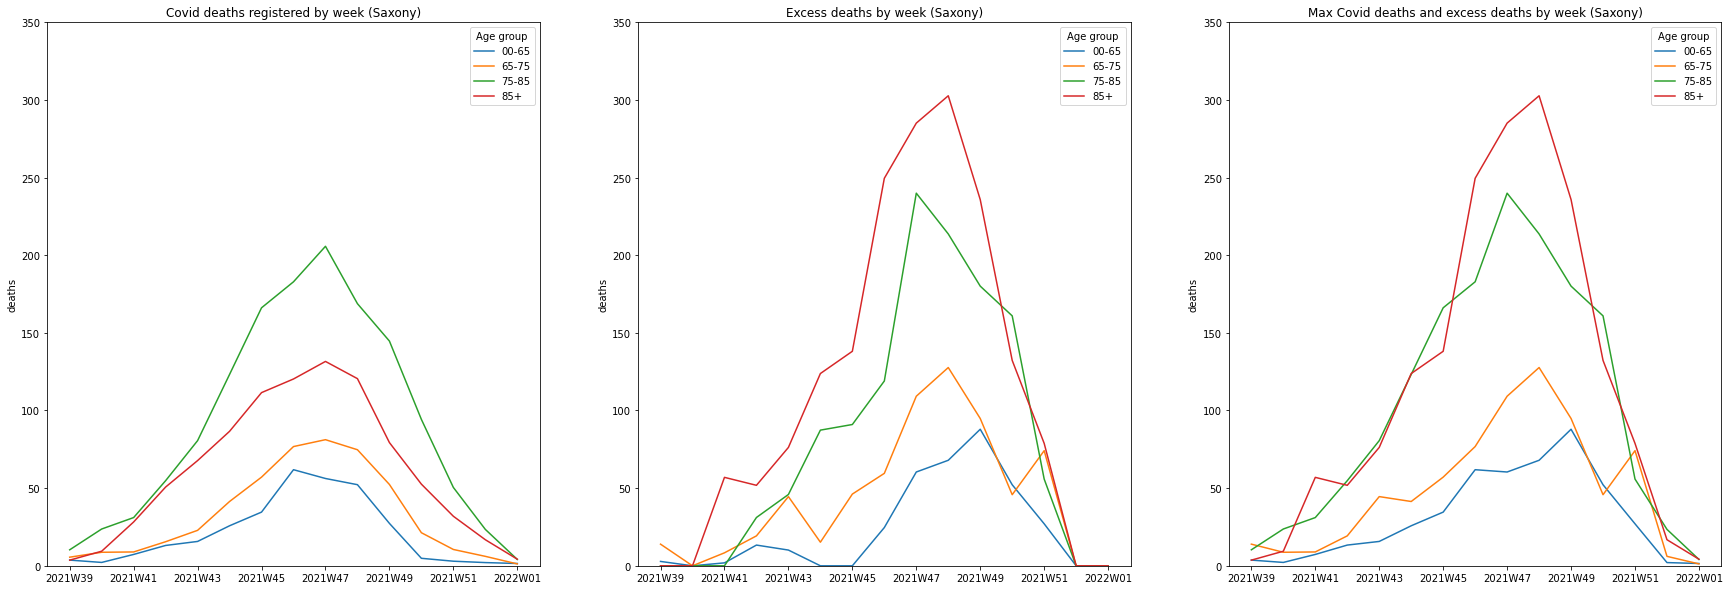

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
weekly_regional_deaths.T.plot(ax=axes[0])
axes[0].set_title('Covid deaths registered by week (Saxony)')
axes[0].set_ylabel('deaths')
axes[0].set_ylim([0, 350])

excess_deaths.T.plot(ax=axes[1])
axes[1].set_title('Excess deaths by week (Saxony)')
axes[1].set_ylabel('deaths')
axes[1].set_ylim([0, 350])

x = pd.concat([weekly_regional_deaths, excess_deaths]).max(level=0)
x.T.plot(ax=axes[2])
axes[2].set_title('Max Covid deaths and excess deaths by week (Saxony)')
axes[2].set_ylabel('deaths')
axes[2].set_ylim([0, 350])
plt.savefig('new/Saxony_covid_deaths.png')

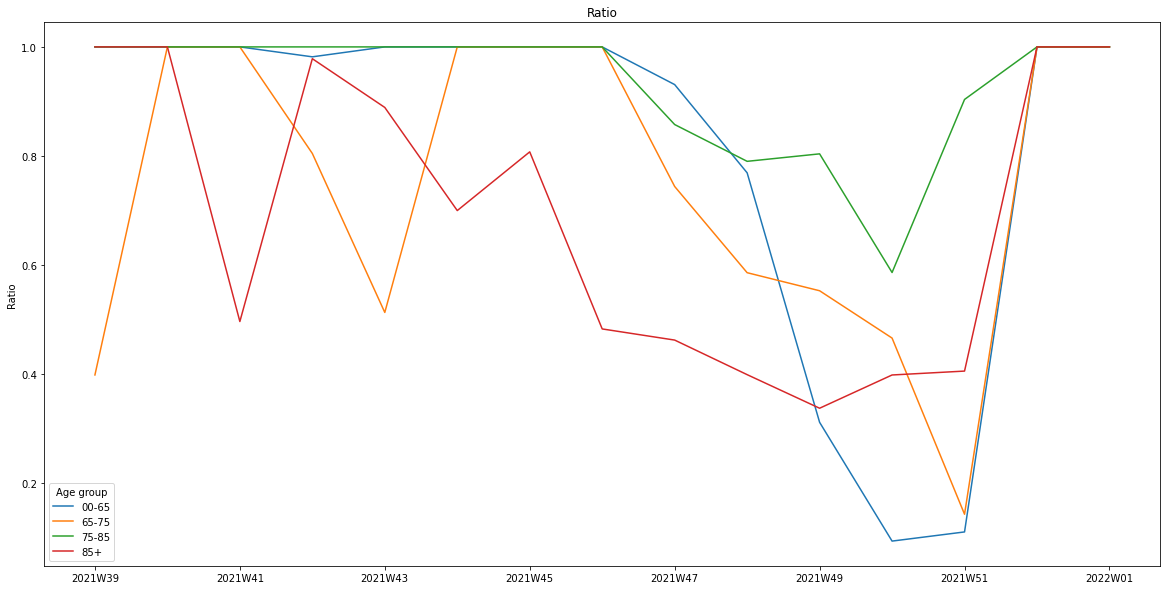

In [17]:
ratio.T.plot(figsize=(20, 10))
plt.ylabel('Ratio')
plt.title('Ratio')
plt.savefig('new/Saxony_ratio.png')
plt.show()

In [18]:
covid_deaths_shifted = covid_deaths.iloc[0, -56:-4]
covid_max_line = covid_deaths.iloc[0, -55:-3].to_numpy() - covid_deaths_shifted.to_numpy()
covid_max_line

array([3.70714286e+01, 2.70285714e+01, 1.63000000e+01, 1.42142857e+01,
       6.87142857e+00, 6.15714286e+00, 4.57142857e+00, 5.22857143e+00,
       6.84285714e+00, 8.25714286e+00, 1.49714286e+01, 2.30571429e+01,
       2.20428571e+01, 1.78571429e+01, 2.13714286e+01, 1.61571429e+01,
       1.84285714e+01, 1.27000000e+01, 9.50000000e+00, 3.68571429e+00,
       1.08571429e+00, 3.02857143e+00, 9.71428571e-01, 1.12857143e+00,
       1.71428571e-01, 0.00000000e+00, 0.00000000e+00, 1.42857143e-02,
       8.57142857e-02, 4.28571429e-02, 5.71428571e-02, 7.14285714e-02,
       4.28571429e-02, 6.28571429e-01, 2.64285714e+00, 4.37142857e+00,
       2.77142857e+00, 2.81428571e+00, 3.10000000e+00, 3.67142857e+00,
       2.17142857e+00, 7.31428571e+00, 1.31000000e+01, 1.56857143e+01,
       2.57714286e+01, 3.45714286e+01, 6.18714286e+01, 5.62142857e+01,
       5.22285714e+01, 2.73142857e+01, 4.82857143e+00, 2.95714286e+00])

In [19]:
prev_y = total_deaths[total_deaths['Year'] < 2020].drop(columns='Region').set_index('Age group')
max_line = prev_y.loc['Total', 1:52].apply(max)

In [20]:
df = covid_deaths.append(pd.DataFrame(covid_deaths.sum(axis=0), columns=['Total']).T)
covid_deaths_r = df.iloc[:, 1:].to_numpy() - df.iloc[:, :-1].to_numpy()
covid_deaths_r = pd.DataFrame(covid_deaths_r)
covid_deaths_r.index = df.index
covid_deaths_r.columns = df.iloc[:, 1:].columns
covid_deaths_r_2020 = covid_deaths_r.iloc[:, :42]
covid_deaths_r_2021 = covid_deaths_r.iloc[:, 43:-3]
covid_deaths_r.index

Index(['00-65', '65-75', '75-85', '85+', 'Total'], dtype='object')

In [21]:
max_line_sum_max = prev_y.loc[['00-65', '65-75', '75-85', '85+'], 1:52].groupby('Age group').max().sum()
max_line_max_sum = prev_y.loc['Total', 1:52].apply(max)
max_line_sum_max - max_line_max_sum
#     prev = total_deaths[total_deaths['Year'] == 2021].drop(columns='Region').set_index('Age group')
#     prev.loc[[age_group], 1:52].T.plot(figsize=(15, 8))
    
    
    
#     max_line.T.plot(style='k')
#     plt.plot(np.arange(1, 53), covid_deaths_r_2021.loc[age_group, :].to_numpy() + max_line)
#     plt.legend(['Total deaths', 'max prev deaths', 'max + covid deaths'])
#     plt.title(f'Total deaths 2021 ({age_group})')
#     plt.xlabel('week')
#     plt.ylabel('deaths')
#     plt.ylim([0, max_lim])
#     plt.savefig(f'new/Saxony_deaths_{age_group}_2021.png')


1     21.0
2      0.0
3     10.0
4     30.0
5     11.0
6      0.0
7     21.0
8     76.0
9      0.0
10     6.0
11     0.0
12     2.0
13    15.0
14    12.0
15    33.0
16    39.0
17    58.0
18    19.0
19    58.0
20    29.0
21    36.0
22    30.0
23     5.0
24     7.0
25    32.0
26     0.0
27    24.0
28    75.0
29    67.0
30    28.0
31     0.0
32     3.0
33     8.0
34    27.0
35    10.0
36    51.0
37    24.0
38    37.0
39    48.0
40    69.0
41     1.0
42    28.0
43    14.0
44     0.0
45     8.0
46    38.0
47    57.0
48    74.0
49    21.0
50    40.0
51    10.0
52     0.0
dtype: float64

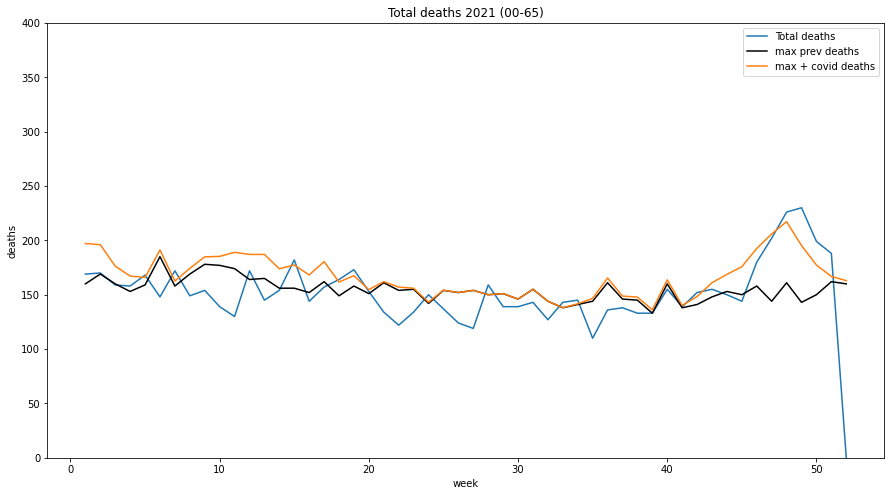

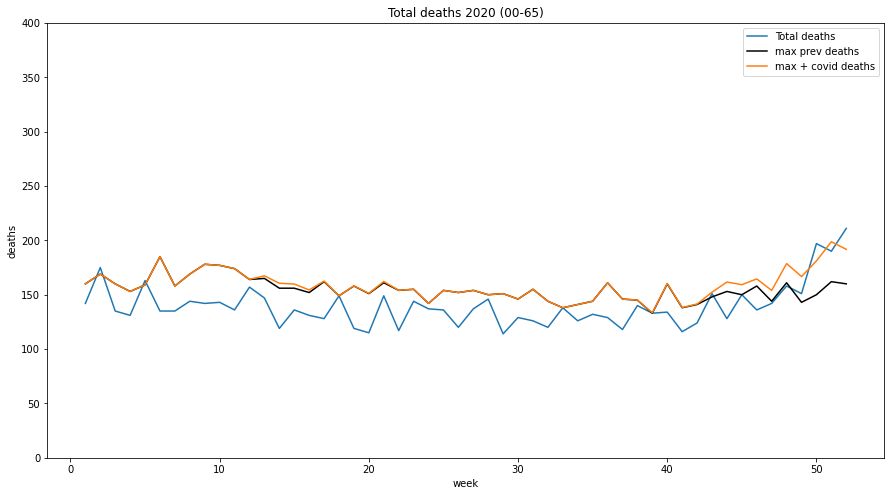

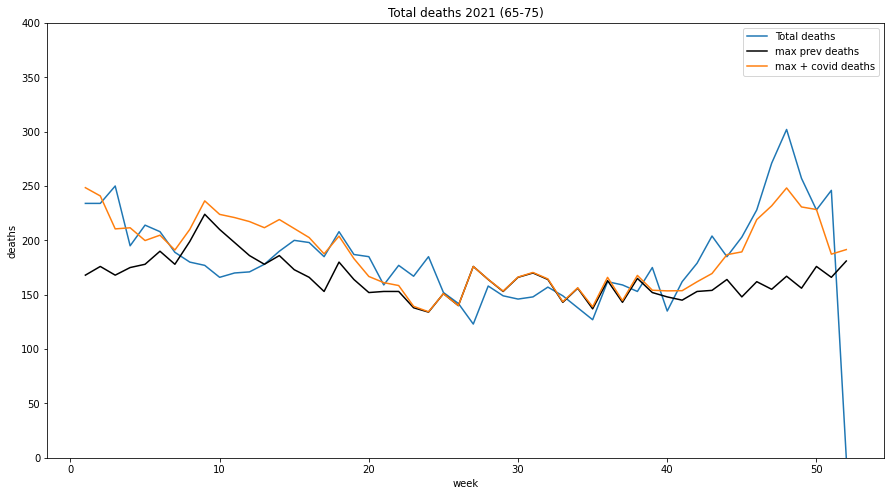

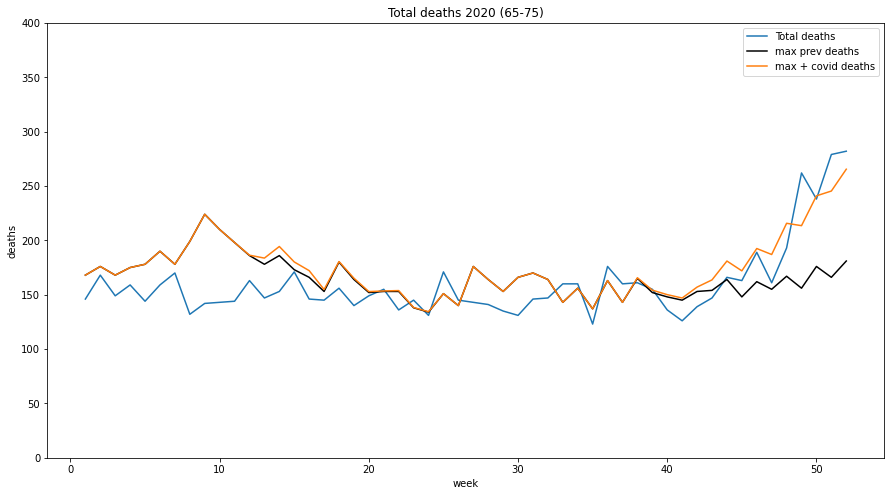

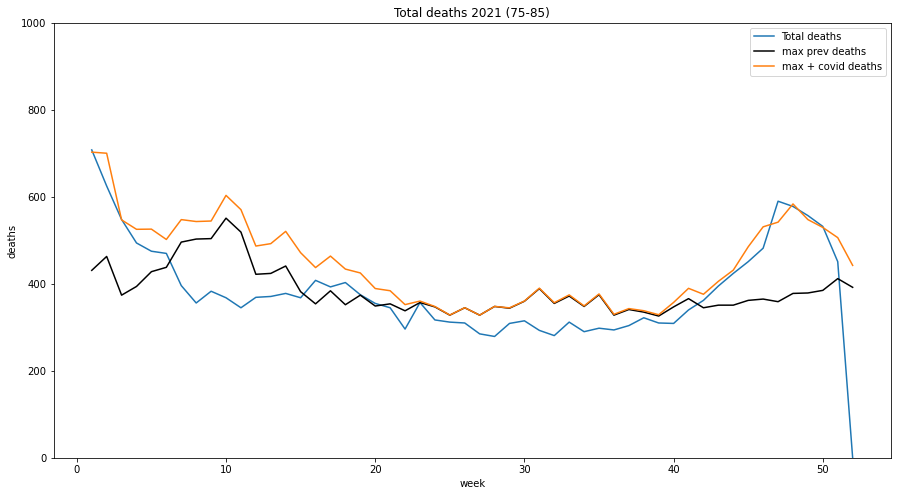

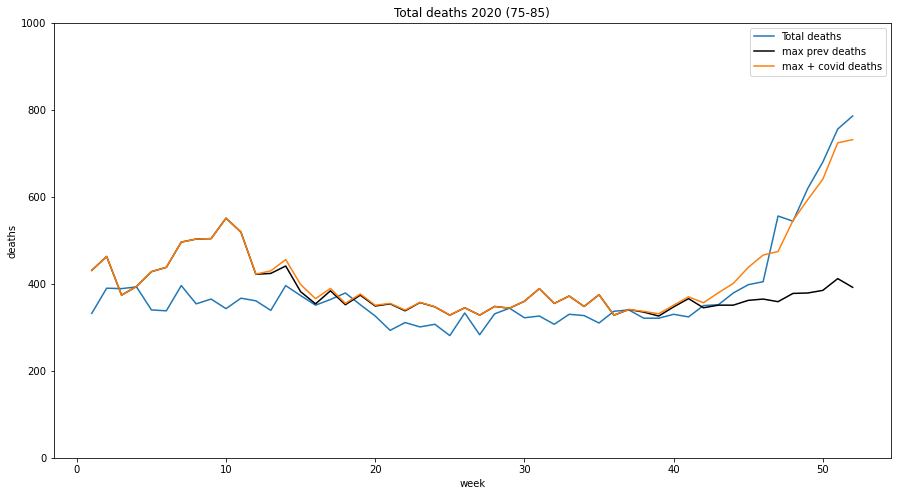

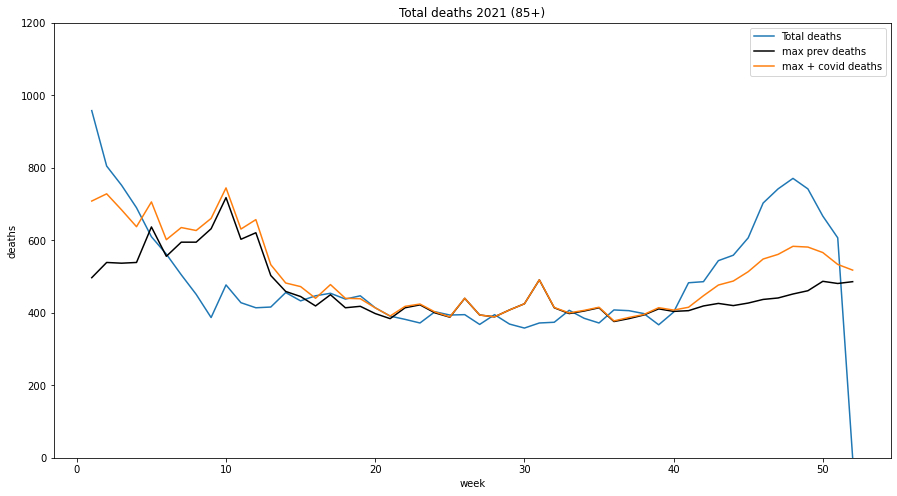

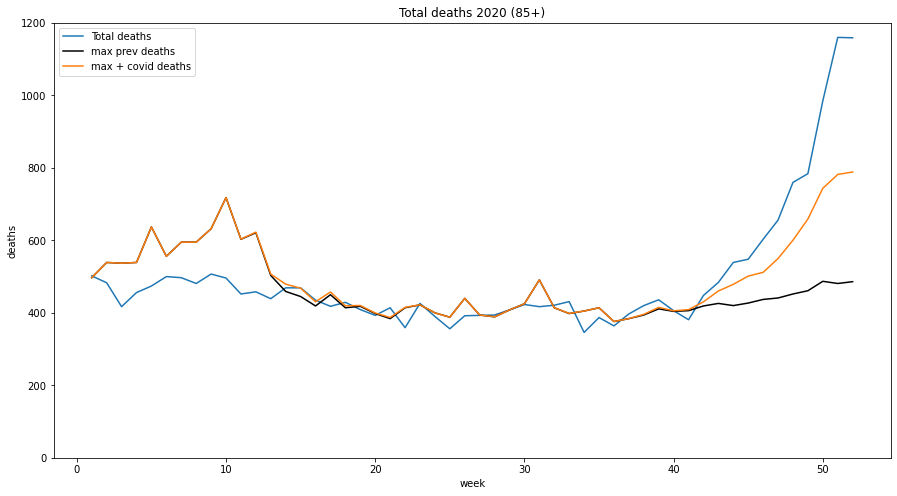

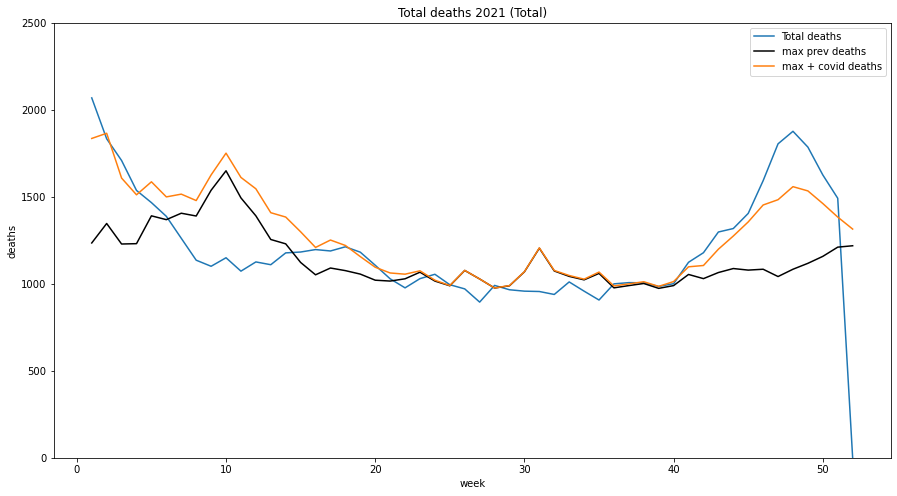

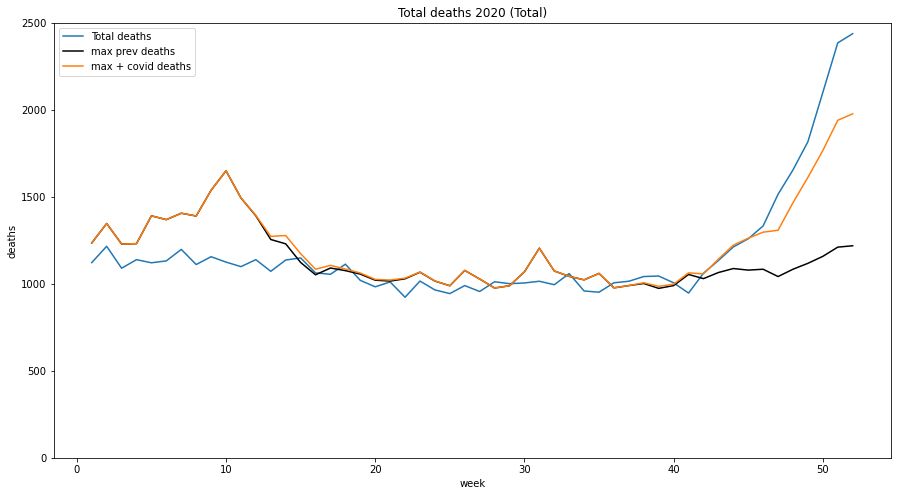

In [22]:
for age_group, max_lim in zip(covid_deaths_r.index, [400, 400, 1000, 1200, 2500]):
    max_line = prev_y.loc[age_group, 1:52].apply(max)
    prev = total_deaths[total_deaths['Year'] == 2021].drop(columns='Region').set_index('Age group')
    prev.loc[[age_group], 1:52].T.plot(figsize=(15, 8))
    max_line.T.plot(style='k')
    plt.plot(np.arange(1, 53), covid_deaths_r_2021.loc[age_group, :].to_numpy() + max_line)
    plt.legend(['Total deaths', 'max prev deaths', 'max + covid deaths'])
    plt.title(f'Total deaths 2021 ({age_group})')
    plt.xlabel('week')
    plt.ylabel('deaths')
    plt.ylim([0, max_lim])
    plt.savefig(f'new/Saxony_deaths_{age_group}_2021.png')
    
    
    
    prev = total_deaths[total_deaths['Year'] == 2020].drop(columns='Region').set_index('Age group')
    prev.loc[[age_group], 1:52].T.plot(figsize=(15, 8))
    max_line.T.plot(style='k')
    plt.plot(np.arange(1, 53), np.concatenate([np.zeros(10), covid_deaths_r_2020.loc[age_group, :].to_numpy()]) + max_line)
    plt.legend(['Total deaths', 'max prev deaths', 'max + covid deaths'])
    plt.title(f'Total deaths 2020 ({age_group})')
    plt.xlabel('week')
    plt.ylabel('deaths')
    plt.ylim([0, max_lim])
    plt.savefig(f'new/Saxony_deaths_{age_group}_2020.png')
    